In [0]:
!pip install tensorflow-gpu==2.0.0.a0

In [0]:
!pip install tensorflow-addons
!pip install tqdm
!pip install kaa-imlib2

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from functools import partial
from skimage import color, transform
import matplotlib.pyplot as plt
import numpy as np
# import pylib as py
import os
# import tf2gan as gan
import tqdm
import glob
import sys
from torchvision import datasets
tf.__version__

'2.0.0-alpha0'

In [0]:
!mkdir mnist
!mkdir svhn
!mkdir checkpoints

In [0]:
BUFFER_SIZE = 6000
BATCH_SIZE = 512

#Prepare SVHN

In [0]:
folder_mnist = "./mnist"
folder_svhn = "./svhn"
svhn_train = datasets.SVHN(root=folder_svhn, download=True, split="train")
svhn_test = datasets.SVHN(root=folder_svhn, download=True, split="test")

In [0]:
def transform_svhn(X):
    X = np.transpose(X, (0,2,3,1))
    X = np.array(X, np.float32)
    X /= 255
    X = X.reshape(len(X), 32, 32, 3)
    return X

In [0]:
print("Transforming SVHN train...")
X_svhn_train = transform_svhn(svhn_train.data)
X_svhn_validation = X_svhn_train[-10000:]
X_svhn_train = X_svhn_train[:-10000]
print("Transforming SVHN test...")
X_svhn_test = transform_svhn(svhn_test.data)

train_dataset_svhn = tf.data.Dataset.from_tensor_slices(X_svhn_train).shuffle(63257).repeat().batch(BATCH_SIZE)
validation_dataset_svhn = tf.data.Dataset.from_tensor_slices(X_svhn_train).shuffle(10000).repeat().batch(BATCH_SIZE)
test_dataset_svhn = tf.data.Dataset.from_tensor_slices(X_svhn_test).shuffle(26032).repeat().batch(200)

print(X_svhn_train.shape)
print(X_svhn_validation.shape)
print(X_svhn_test.shape)

Transforming SVHN train...
Transforming SVHN test...


182042624it [00:30, 14081773.58it/s]                               

(63257, 32, 32, 3)
(10000, 32, 32, 3)
(26032, 32, 32, 3)


In [0]:
!mkdir svhn_validation
!mkdir svhn_test

In [0]:
for i in range(len(X_svhn_validation)):
  plt.imsave('svhn_validation/{}.jpg'.format(i), np.array(X_svhn_validation[i]))


64282624it [00:20, 15064044.23it/s]                              

In [0]:
for i in range(len(X_svhn_test)):
  plt.imsave('svhn_test/{}.jpg'.format(i), np.array(X_svhn_test[i]))

#Prepare *MNIST*

In [0]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def transform_mnist(X):
#     X = X.reshape(len(X), 28, 28)
    X = np.array([transform.resize(im, [32,32]) for im in X])
    X /= 255
    X = X.reshape(len(X), 32, 32, 1)
    return X.astype('float32')

In [0]:
print("Transforming MNIST train...")
X_mnist_train = transform_mnist(train_images)
X_mnist_validation = X_mnist_train[-10000:]
X_mnist_train = X_mnist_train[:-10000]
X_mnist_test = transform_mnist(test_images)

train_dataset_mnist = tf.data.Dataset.from_tensor_slices(X_mnist_train).shuffle(50000).repeat().batch(BATCH_SIZE)
validation_dataset_mnist = tf.data.Dataset.from_tensor_slices(X_mnist_train).shuffle(10000).repeat().batch(BATCH_SIZE)
test_dataset_mnist = tf.data.Dataset.from_tensor_slices(X_mnist_test).shuffle(10000).repeat().batch(200)


Transforming MNIST train...


In [0]:
print(X_mnist_train.shape)
print(X_mnist_validation.shape)
print(X_mnist_test.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)
(10000, 32, 32, 1)


In [0]:
!mkdir mnist_validation
!mkdir mnist_test

In [0]:
for i in range(len(X_mnist_validation)):
  plt.imsave('mnist_validation/{}.jpg'.format(i), np.array(X_mnist_validation[i]).reshape(32,32))

In [0]:
for i in range(len(X_mnist_test)):
  plt.imsave('mnist_test/{}.jpg'.format(i), np.array(X_mnist_test[i]).reshape(32,32))

In [0]:
itA = iter(train_dataset_mnist)
itB = iter(train_dataset_svhn)
itA_test = iter(test_dataset_mnist)
itB_test = iter(test_dataset_svhn)
itA_validation = iter(validation_dataset_mnist)
itB_validation = iter(validation_dataset_svhn)

In [0]:
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return tfa.layers.LayerNormalization

def build_generator(input_shape,output_shape=None,kernel_size=3):

    Norm = _get_norm_layer('instance_norm')
    dim = 32
    n_downsamplings=2
    n_blocks=3
    norm='instance_norm'
    channels = int(output_shape[-1])
    
    def _residual_block(x):
        dim = x.shape[-1]
        h = x

#         h = Pad([[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')(h)
        h = keras.layers.Conv2D(dim, 3, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.ReLU()(h)

#         h = Pad([[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')(h)
        h = keras.layers.Conv2D(dim, 3, padding='same', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)
#     1
#     h = Pad([[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')(h)
    h = keras.layers.Conv2D(dim, 7, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = keras.layers.ReLU()(h)

    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.ReLU()(h)

    # 3
    for _ in range(n_blocks):
        h = _residual_block(h)
    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = keras.layers.ReLU()(h)
    # 5
#     h = Pad([[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')(h)
    h = keras.layers.Conv2D(channels, 5, padding='same')(h)
    h = keras.layers.Activation('sigmoid')(h)

    return keras.Model(inputs=inputs, outputs=h)      

def encoder_layer(inputs, filters=16, kernel_size=3, strides=2, activation='relu', instance_norm=True):
    
    x = inputs    
    if instance_norm:
      x = tfa.layers.InstanceNormalization()(x)     
    x = keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=True)(x)
    if activation == 'relu':
      x = keras.layers.ReLU()(x)
    else:
      x = keras.layers.LeakyReLU(alpha=0.2)(x)
    return x  
  
def build_discriminator(input_shape,kernel_size=5):

    inputs = keras.Input(shape=input_shape)
    x = encoder_layer(inputs,32,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,64,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,128,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,256,kernel_size=kernel_size,strides=1,activation='leaky_relu',instance_norm=False)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation('sigmoid')(x)


    discriminator = keras.Model(inputs, outputs)

    return discriminator

In [0]:
import datetime
def train_cyclegan(models, epochs, save_dir):
    # the models
    g_source, g_target, d_source, d_target, adv = models
    epochs = epochs
    # network parameters
    batch_size = 512
    train_steps =20000
    save_interval = 500
    valid = np.ones([batch_size, 1])
    fake = np.zeros([batch_size, 1])
    titles = ('MNIST predicted source images.','SVHN predicted target images.','MNIST reconstructed source images.','SVHN reconstructed target images.')

    valid_fake = np.concatenate((valid, fake))
    start_time = datetime.datetime.now()
    
    for ep in range(epochs):
      print(ep)
      #124 = len of svhn dataset / batch dimension
      for i in range(124):
        # train for an epoch
        real_source, real_target  = next(itA), next(itB)
#         if ep==0 and i==0:
#           test_generator((g_source, g_target), (real_source, real_target), 0, titles=titles, dirs=('./', './'), show=True)

        fake_target = g_target.predict(real_source)

        # combine real and fake into one batch
        x = np.concatenate((real_target, fake_target))
        # train the target discriminator using fake/real data
        metrics = d_target.train_on_batch(x, valid_fake)
        log = "%d: [d_target loss: %f]" % (i, metrics[0])

        # generate a batch of fake source data fr real target data
        fake_source = g_source.predict(real_target)
        x = np.concatenate((real_source, fake_source))
        # train the source discriminator using fake/real data
        metrics = d_source.train_on_batch(x, valid_fake)
        log = "%s [d_source loss: %f]" % (log, metrics[0])

        # train the adversarial network using forward and backward
        # cycles. the generated fake source and target data attempts
        # to trick the discriminators
        x = [real_source, real_target]
        y = [valid, valid, real_source, real_target]
        metrics = adv.train_on_batch(x, y)
        elapsed_time = datetime.datetime.now() - start_time
        fmt = "%s [adv loss: %f] [time: %s]"
        log = fmt % (log, metrics[0], elapsed_time)
#         if (i) % save_interval == 0:
      print(log)
      A = real_source
      B = real_target
    test_generator((g_source, g_target), (A, B), epochs, titles=titles, dirs=('./', './'), show=True)
    save_images((g_source, g_target), save_dir)

In [0]:
def build_cyclegan(source_name='source', target_name='target',kernel_size=5):

    source_shape = (32,32,1)
    target_shape = (32,32,3)
    lr = 2e-4
    decay = 6e-8
    gt_name = "gen_" + target_name
    gs_name = "gen_" + source_name
    dt_name = "dis_" + target_name
    ds_name = "dis_" + source_name

    # build target and source generators
    g_target = build_generator(input_shape=(32, 32, 1), output_shape=(32,32,3), kernel_size=kernel_size)
    g_source = build_generator(input_shape=(32, 32, 3), output_shape=(32,32,1), kernel_size=kernel_size)
    print('---- TARGET GENERATOR ----')
    g_target.summary()
    print('---- SOURCE GENERATOR ----')
    g_source.summary()

    # build target and source discriminators
    d_target = build_discriminator((32,32,3), kernel_size=kernel_size)
    d_source = build_discriminator((32,32,1), kernel_size=kernel_size)
    
    print('---- TARGET DISCRIMINATOR ----')
    d_target.summary()
    print('---- SOURCE DISCRIMINATOR ----')
    d_source.summary()

    optimizer = keras.optimizers.RMSprop(lr=lr, decay=decay)
    d_target.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    d_source.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

#     d_target.trainable = False
    for layer in d_target.layers:
        layer.trainable=False
    for layer in d_source.layers:
        layer.trainable=False        
#     d_source.trainable = False

    # build the computational graph for the adversarial model
    # forward cycle network and target discriminator
    source_input = keras.Input(shape=source_shape)
    fake_target = g_target(source_input)
    preal_target = d_target(fake_target)
    reco_source = g_source(fake_target)

    # backward cycle network and source discriminator
    target_input = keras.Input(shape=target_shape)
    fake_source = g_source(target_input)
    preal_source = d_source(fake_source)
    reco_target = g_target(fake_source)

    loss = ['binary_crossentropy', 'binary_crossentropy', 'mae', 'mae']
    loss_weights = [1., 1., 5., 5.]
    inputs = [source_input, target_input]
    outputs = [preal_source,
               preal_target,
               reco_source,
               reco_target]

    # build adversarial model
    adv = keras.Model(inputs, outputs, name='adversarial')
    optimizer = keras.optimizers.RMSprop(lr=lr*0.5, decay=decay*0.5)
    adv.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
    print('---- ADVERSARIAL NETWORK ----')
    adv.summary()

    return g_source, g_target, d_source, d_target, adv

In [0]:
def save_images(generators, save_dir):
    g_source = generators[0]
    g_target = generators[1]
    for j in range(20):
        real_source, real_target  = next(itA_validation), next(itB_validation)        
        pred_target_data = g_target.predict(real_source)
        pred_source_data = g_source.predict(real_target)
        for i in range(len(pred_target_data)):
          plt.imsave('{}mnist/{}.jpg'.format(save_dir,j*512+i), np.array(pred_source_data[i]).reshape(32,32))
          plt.imsave('{}svhn/{}.jpg'.format(save_dir,j*512+i), pred_target_data[i])

In [0]:
def test_generator(generators, test_data,step,titles,dirs,todisplay=100,show=False):
  
    # predict the output from test data
    g_source, g_target = generators
    test_source_data, test_target_data = test_data
    t1, t2, t3, t4 = titles
    title_pred_source = t1
    title_pred_target = t2
    title_reco_source = t3
    title_reco_target = t4
    dir_pred_source, dir_pred_target = dirs

    pred_target_data = g_target.predict(test_source_data)
    pred_source_data = g_source.predict(test_target_data)
    reco_source_data = g_source.predict(pred_target_data)
    reco_target_data = g_target.predict(pred_source_data)

    # display the 1st todisplay images
    imgs = pred_target_data[:todisplay]
    filename = 'svhn-{}.png'.format(step)
#     step = " Step: {:,}".format(step)
    title = title_pred_target 
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)
    
    filename = 'mnist-{}.png'.format(step)
    imgs = pred_source_data[:todisplay]
    title = title_pred_source
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_source_data[:todisplay]
    title = title_reco_source
    filename = "reconstructed_source{}.png".format(step)
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_target_data[:todisplay]
    title = title_reco_target
    filename = "reconstructed_target{}.png".format(step)
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                    show=show)

In [0]:
import math
def display_images(imgs,filename,title='',imgs_dir=None,show=False):

    rows = imgs.shape[1]
    cols = imgs.shape[2]
    channels = imgs.shape[3]
    side = int(math.sqrt(imgs.shape[0]))
    assert int(side * side) == imgs.shape[0]

    # create saved_images folder
    if imgs_dir is None:
        imgs_dir = 'saved_images'
    save_dir = os.path.join(os.getcwd(), imgs_dir)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = os.path.join(imgs_dir, filename)
    # rows, cols, channels = img_shape
    if channels==1:
        imgs = imgs.reshape((side, side, rows, cols))
    else:
        imgs = imgs.reshape((side, side, rows, cols, channels))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.axis('off')
#     plt.title(title)
    if channels==1:
        plt.imshow(imgs, interpolation='none', cmap='gray')
    else:
        plt.imshow(imgs, interpolation='none')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True)
    if show:
        plt.show()
    
    plt.close('all')

In [0]:
!git clone https://github.com/mseitzer/pytorch-fid.git

In [0]:
models = build_cyclegan("mnist", "svhn", kernel_size=5)

In [0]:
!mkdir 1mnist
!mkdir 1svhn

!mkdir 50mnist
!mkdir 50svhn

!mkdir 100mnist
!mkdir 100svhn

!mkdir 150mnist
!mkdir 150svhn

!mkdir 200mnist
!mkdir 200svhn

!mkdir 250mnist
!mkdir 250svhn

!mkdir 300mnist
!mkdir 300svhn

!mkdir 350mnist
!mkdir 350svhn

!mkdir 400mnist
!mkdir 400svhn

0


W0616 08:19:21.215803 140134066329472 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0616 08:19:22.737623 140134066329472 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


123: [d_target loss: 0.661277] [d_source loss: 0.279094] [adv loss: 4.474341] [time: 0:02:14.318389]


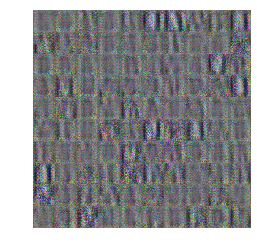

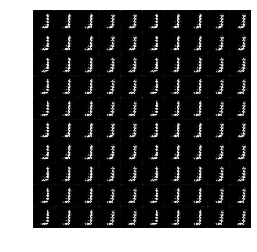

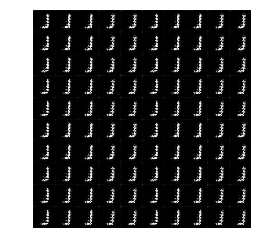

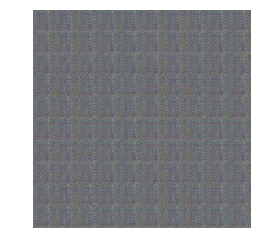

In [0]:
train_cyclegan(models, 1, '1')

In [0]:
!python pytorch-fid/fid_score.py 1svhn svhn_validation.npz --gpu 0

0
123: [d_target loss: 0.666434] [d_source loss: 0.757146] [adv loss: 3.786150] [time: 0:01:48.705160]
1
123: [d_target loss: 0.689970] [d_source loss: 0.328943] [adv loss: 4.281496] [time: 0:03:36.793201]
2
123: [d_target loss: 0.622953] [d_source loss: 0.536261] [adv loss: 3.560087] [time: 0:05:24.892845]
3
123: [d_target loss: 0.632877] [d_source loss: 0.637144] [adv loss: 3.815101] [time: 0:07:13.370377]
4
123: [d_target loss: 0.650075] [d_source loss: 0.671644] [adv loss: 2.508210] [time: 0:09:01.588182]
5
123: [d_target loss: 0.671974] [d_source loss: 0.628933] [adv loss: 2.913201] [time: 0:10:49.839112]
6
123: [d_target loss: 0.845979] [d_source loss: 0.669488] [adv loss: 2.722857] [time: 0:12:38.024812]
7
123: [d_target loss: 0.585145] [d_source loss: 0.610462] [adv loss: 2.783662] [time: 0:14:26.137134]
8
123: [d_target loss: 0.742673] [d_source loss: 0.638725] [adv loss: 2.728322] [time: 0:16:14.547999]
9
123: [d_target loss: 0.651542] [d_source loss: 0.601096] [adv loss: 2.5

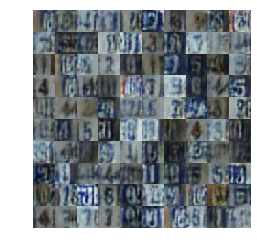

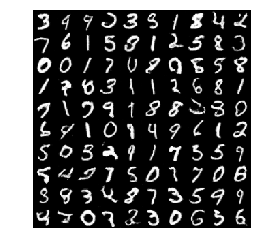

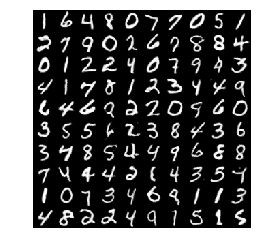

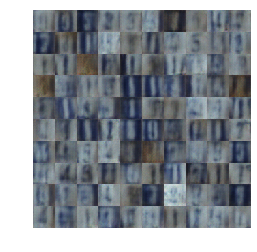

In [0]:
train_cyclegan(models, 49, '50')

0
123: [d_target loss: 0.588890] [d_source loss: 0.590678] [adv loss: 3.513483] [time: 0:01:46.938963]
1
123: [d_target loss: 0.649588] [d_source loss: 0.586803] [adv loss: 3.054321] [time: 0:03:34.621456]
2
123: [d_target loss: 0.660299] [d_source loss: 0.582216] [adv loss: 3.108804] [time: 0:05:22.841332]
3
123: [d_target loss: 0.618440] [d_source loss: 0.559296] [adv loss: 3.491356] [time: 0:07:10.894672]
4
123: [d_target loss: 0.594584] [d_source loss: 0.572930] [adv loss: 3.558449] [time: 0:08:58.897133]
5
123: [d_target loss: 0.619754] [d_source loss: 0.560709] [adv loss: 3.047496] [time: 0:10:47.055614]
6
123: [d_target loss: 0.686150] [d_source loss: 0.572860] [adv loss: 3.124158] [time: 0:12:35.131091]
7
123: [d_target loss: 0.605032] [d_source loss: 0.590828] [adv loss: 3.262044] [time: 0:14:23.295487]
8
123: [d_target loss: 0.628128] [d_source loss: 0.540024] [adv loss: 2.585807] [time: 0:16:11.423041]
9
123: [d_target loss: 0.585538] [d_source loss: 0.612864] [adv loss: 3.4

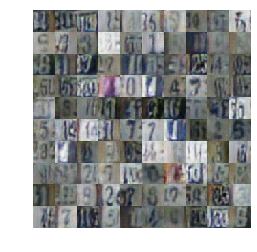

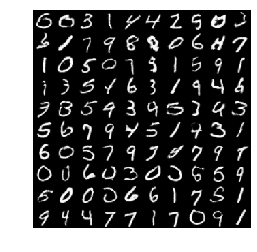

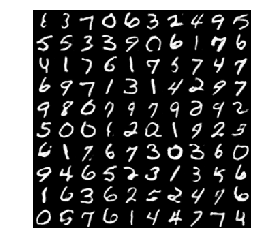

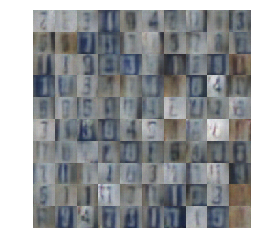

In [0]:
train_cyclegan(models, 50, '100')

0
123: [d_target loss: 0.559894] [d_source loss: 0.367932] [adv loss: 4.940659] [time: 0:01:46.837482]
1
123: [d_target loss: 0.544937] [d_source loss: 0.345073] [adv loss: 4.812708] [time: 0:03:34.540372]
2
123: [d_target loss: 0.593713] [d_source loss: 0.314914] [adv loss: 3.494280] [time: 0:05:22.513574]
3
123: [d_target loss: 0.584959] [d_source loss: 0.360392] [adv loss: 4.170408] [time: 0:07:10.461466]
4
123: [d_target loss: 0.524990] [d_source loss: 0.410506] [adv loss: 5.248543] [time: 0:08:58.563052]
5
123: [d_target loss: 0.563650] [d_source loss: 0.352836] [adv loss: 3.663876] [time: 0:10:46.661119]
6
123: [d_target loss: 0.556026] [d_source loss: 0.444582] [adv loss: 4.797907] [time: 0:12:34.645910]
7
123: [d_target loss: 0.640969] [d_source loss: 0.395241] [adv loss: 3.941525] [time: 0:14:22.675312]
8
123: [d_target loss: 0.596930] [d_source loss: 0.375009] [adv loss: 5.373687] [time: 0:16:10.653415]
9
123: [d_target loss: 0.612840] [d_source loss: 0.514035] [adv loss: 3.9

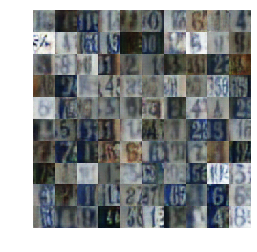

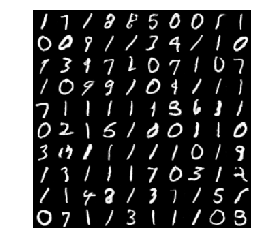

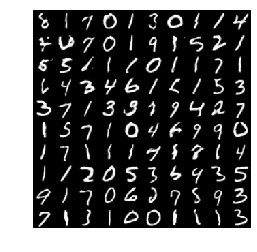

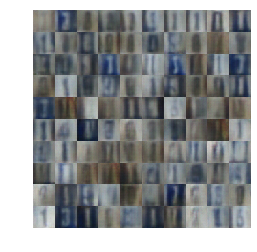

In [0]:
train_cyclegan(models, 50, '100')

0
123: [d_target loss: 0.646319] [d_source loss: 0.133421] [adv loss: 6.081768] [time: 0:01:48.119159]
1
123: [d_target loss: 0.558715] [d_source loss: 0.256466] [adv loss: 5.161795] [time: 0:03:36.091924]
2
123: [d_target loss: 0.527756] [d_source loss: 0.203100] [adv loss: 5.139988] [time: 0:05:23.989508]
3
123: [d_target loss: 0.543271] [d_source loss: 0.215588] [adv loss: 6.074620] [time: 0:07:11.964898]
4
123: [d_target loss: 0.534998] [d_source loss: 0.151158] [adv loss: 6.836224] [time: 0:08:59.852859]
5
123: [d_target loss: 0.578485] [d_source loss: 0.251456] [adv loss: 4.040278] [time: 0:10:47.797125]
6
123: [d_target loss: 0.701427] [d_source loss: 0.194246] [adv loss: 7.183397] [time: 0:12:35.741298]
7
123: [d_target loss: 0.587730] [d_source loss: 0.151161] [adv loss: 5.496191] [time: 0:14:23.593814]
8
123: [d_target loss: 0.555665] [d_source loss: 0.202694] [adv loss: 6.751891] [time: 0:16:11.561653]
9
123: [d_target loss: 0.562279] [d_source loss: 0.169496] [adv loss: 5.4

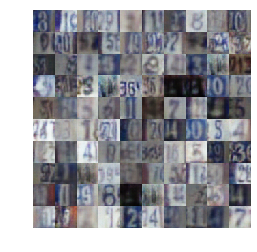

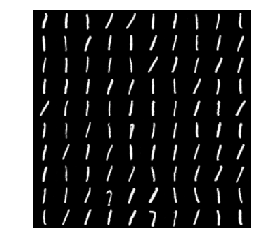

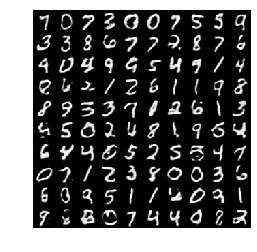

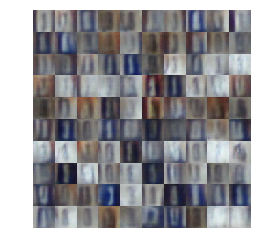

In [0]:
train_cyclegan(models, 50, '150')

0
123: [d_target loss: 0.601947] [d_source loss: 0.122013] [adv loss: 6.904664] [time: 0:01:48.228723]
1
123: [d_target loss: 0.557618] [d_source loss: 0.092297] [adv loss: 6.593025] [time: 0:03:36.357761]
2
123: [d_target loss: 0.518620] [d_source loss: 0.213145] [adv loss: 6.393826] [time: 0:05:24.212989]
3
123: [d_target loss: 0.510500] [d_source loss: 0.109360] [adv loss: 6.398118] [time: 0:07:12.102394]
4
123: [d_target loss: 0.524216] [d_source loss: 0.129632] [adv loss: 7.330122] [time: 0:09:00.178917]
5
123: [d_target loss: 0.565277] [d_source loss: 0.270960] [adv loss: 8.310603] [time: 0:10:48.119055]
6
123: [d_target loss: 0.512274] [d_source loss: 0.119765] [adv loss: 6.043926] [time: 0:12:36.050095]
7
123: [d_target loss: 0.517398] [d_source loss: 0.125421] [adv loss: 5.296780] [time: 0:14:24.086436]
8
123: [d_target loss: 0.509713] [d_source loss: 0.095476] [adv loss: 5.645611] [time: 0:16:12.095721]
9
123: [d_target loss: 0.511095] [d_source loss: 0.147038] [adv loss: 6.5

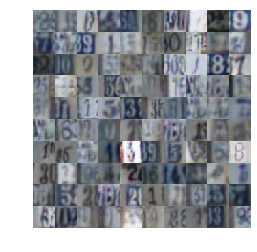

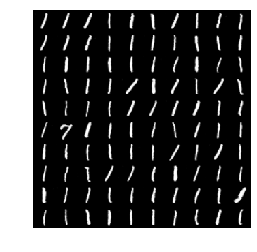

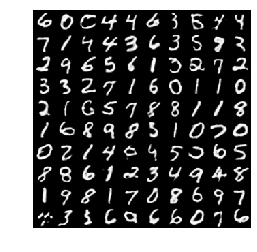

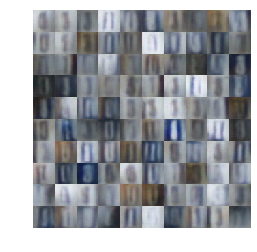

In [0]:
train_cyclegan(models, 50, '200')

0
123: [d_target loss: 0.482578] [d_source loss: 0.202461] [adv loss: 6.098231] [time: 0:01:48.311738]
1
123: [d_target loss: 0.556195] [d_source loss: 0.082736] [adv loss: 8.766798] [time: 0:03:36.436093]
2
123: [d_target loss: 0.476182] [d_source loss: 0.098813] [adv loss: 7.946129] [time: 0:05:24.651673]
3
123: [d_target loss: 0.534266] [d_source loss: 0.124207] [adv loss: 11.363332] [time: 0:07:12.828819]
4
123: [d_target loss: 0.500234] [d_source loss: 0.071936] [adv loss: 8.066588] [time: 0:09:00.791445]
5
123: [d_target loss: 0.478771] [d_source loss: 0.134395] [adv loss: 7.673539] [time: 0:10:48.842950]
6
123: [d_target loss: 0.462757] [d_source loss: 0.085787] [adv loss: 6.296561] [time: 0:12:36.977324]
7
123: [d_target loss: 0.485124] [d_source loss: 0.083876] [adv loss: 5.157274] [time: 0:14:25.001875]
8
123: [d_target loss: 0.472886] [d_source loss: 0.073249] [adv loss: 6.951113] [time: 0:16:13.201063]
9
123: [d_target loss: 0.498640] [d_source loss: 0.088703] [adv loss: 10

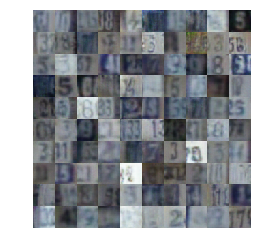

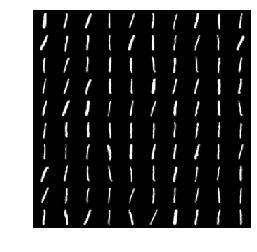

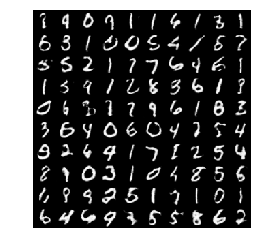

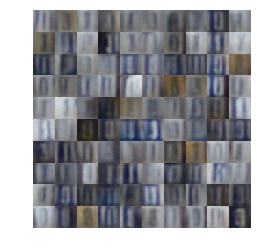

In [0]:
train_cyclegan(models, 50, '250')

0
123: [d_target loss: 0.465806] [d_source loss: 0.059532] [adv loss: 6.574206] [time: 0:01:48.443875]
1
123: [d_target loss: 0.447054] [d_source loss: 0.051010] [adv loss: 7.152235] [time: 0:03:36.633034]
2
123: [d_target loss: 0.453579] [d_source loss: 0.047851] [adv loss: 7.019344] [time: 0:05:24.569838]
3
123: [d_target loss: 0.486245] [d_source loss: 0.027314] [adv loss: 9.454572] [time: 0:07:12.562691]
4
123: [d_target loss: 0.442579] [d_source loss: 0.050989] [adv loss: 9.265407] [time: 0:09:00.884004]
5
123: [d_target loss: 0.415917] [d_source loss: 0.048017] [adv loss: 8.805977] [time: 0:10:49.237058]
6
123: [d_target loss: 0.430807] [d_source loss: 0.121805] [adv loss: 6.627024] [time: 0:12:38.807469]
7
123: [d_target loss: 0.407362] [d_source loss: 0.045576] [adv loss: 8.074945] [time: 0:14:27.079765]
8
123: [d_target loss: 0.409969] [d_source loss: 0.046735] [adv loss: 7.288986] [time: 0:16:15.113513]
9
123: [d_target loss: 0.596392] [d_source loss: 0.068685] [adv loss: 8.0

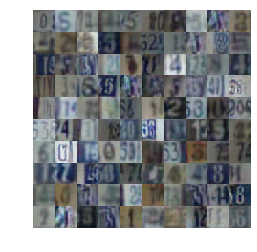

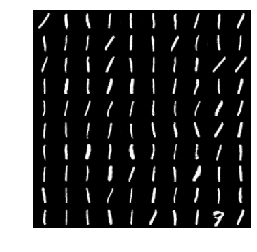

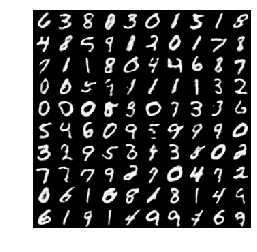

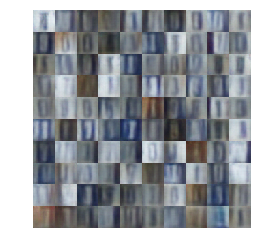

In [0]:
train_cyclegan(models, 50, '300')

In [0]:
train_cyclegan(models, 50, '350')

0
123: [d_target loss: 0.440591] [d_source loss: 0.083705] [adv loss: 8.718371] [time: 0:01:48.247629]
1
123: [d_target loss: 0.403758] [d_source loss: 0.037042] [adv loss: 7.832397] [time: 0:03:36.355460]
2
123: [d_target loss: 0.443641] [d_source loss: 0.085874] [adv loss: 6.739339] [time: 0:05:24.634750]
3
123: [d_target loss: 0.438547] [d_source loss: 0.092286] [adv loss: 6.988302] [time: 0:07:12.729824]
4
123: [d_target loss: 0.406320] [d_source loss: 0.030781] [adv loss: 9.360139] [time: 0:09:00.787324]
5
123: [d_target loss: 0.460807] [d_source loss: 0.081363] [adv loss: 8.334702] [time: 0:10:48.899302]
6
123: [d_target loss: 0.392696] [d_source loss: 0.050419] [adv loss: 8.263189] [time: 0:12:37.013685]
7
123: [d_target loss: 0.382214] [d_source loss: 0.026078] [adv loss: 8.995508] [time: 0:14:25.022779]
8
123: [d_target loss: 0.412723] [d_source loss: 0.031350] [adv loss: 7.613602] [time: 0:16:13.078918]
9
123: [d_target loss: 0.388543] [d_source loss: 0.063419] [adv loss: 12.

In [0]:
train_cyclegan(models, 50, '400')